## AST4310, Autumn 2021, Project 4

Authored by (candidate number): **15508**.

### Header and imports

In [1]:
%%javascript  # Allow equation numbers
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from astropy import units
from astropy import constants
from astropy.table import QTable  # to use tables with units
from astropy.modeling.models import BlackBody  # to compute the Planck function
from astropy.visualization import quantity_support
from matplotlib_inline.backend_inline import set_matplotlib_formats
from numpy import newaxis as nax  # to simplify the many uses of this

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)
plt.rc('figure', figsize=(7, 7 / 1.75)) # Larger figure sizes
plt.rc('font', size=11)

from scipy.integrate import cumtrapz   # for tau integration
from scipy.special import wofz   # for Voigt function
from scipy.optimize import curve_fit

i_units = "kW m-2 sr-1 nm-1"  # More practical SI units

In [3]:
def read_table_units(filename):
    """
    Reads a table in a text file, formatted with column names in first row,
    and unit names on second row. Any deviation from this format will fail.
    
    Modified to use np instead of numpy
    """
    tmp = np.genfromtxt(filename, names=True)
    unit_names = open(filename).readlines()[1][1:].split()
    # Convert to astropy QTable to have units
    data = QTable(tmp)
    # Assign units to quantities in table, use SI units
    for key, unit in zip(data.keys(), unit_names):
        data[key].unit = unit
        data[key] = data[key].si  # We don't want to use deprecated units
    return data

def compute_hminus_cross_section(wavelength, temperature, electron_density):
    """
    Computes the H minus extinction cross section, both free-free and
    bound-free as per Gray (1992).
    
    Modified to use np instead of numpy
    
    Parameters
    ----------
    wavelength : astropy.units.quantity (array)
        Wavelength(s) to calculate in units of length.
    temperature: astropy.units.quantity (scalar or array)
        Gas temperature in units of K or equivalent.
    electron_density: astropy.units.quantity (scalar or array)
        Electron density in units of per cubic length.
        
    Returns
    -------
    extinction : astropy.units.quantity (scalar or array)
        Total H- extinction in si units. 
        Shape: shape of temperature + (nwave,)
    """
    # Broadcast to allow function of temperature and wavelength
    temp = temperature[..., nax]
    wave = wavelength[nax]
    theta = 5040 * units.K / temp
    electron_pressure = electron_density[..., nax] * constants.k_B * temp
    # Compute bound-free opacity for H-, following Gray 8.11-8.12
    sigma_coeff = np.array([2.78701e-23, -1.39568e-18,  3.23992e-14, -4.40524e-10,
                               2.64243e-06, -1.18267e-05,  1.99654e+00])
    sigma_bf = np.polyval(sigma_coeff, wave.to_value('AA'))
    sigma_bf = sigma_bf * 1.e-22 * units.m ** 2
    # Set to zero above the H- ionisation limit at 1644.4 nm
    sigma_bf[wave > 1644.2 * units.nm] = 0.
    # convert into bound-free per neutral H atom assuming Saha,  Gray p156
    k_const = 4.158E-10 * units.cm ** 2 / units.dyn
    gray_saha = k_const * electron_pressure.cgs * theta ** 2.5 * 10. ** (0.754 * theta)
    kappa_bf = sigma_bf * gray_saha                    # per neutral H atom
    # correct for stimulated emission
    kappa_bf *= (1 - np.exp(-constants.h * constants.c / (wave * constants.k_B * temp))) 

    # Now compute free-free opacity, following Gray 8.13
    # coefficients for 4th degree polynomials in the log of wavelength (in AA)
    coeffs = np.array([[-0.0533464, 0.76661, -1.685, -2.2763],
                       [-0.142631, 1.99381, -9.2846, 15.2827],
                       [-0.625151, 10.6913, -67.9775, 190.266, -197.789]])
    log_wave = np.log10(wave.to_value('AA'))
    log_theta = np.log10(theta.value)
    tmp = 0
    for i in range(3):
        tmp += np.polyval(coeffs[i], log_wave) * (log_theta ** i)
    kappa_ff = electron_pressure * (10 ** tmp) 
    kappa_ff = kappa_ff * 1e-26 * (units.cm ** 4) / units.dyn
    return (kappa_bf + kappa_ff).si

In [4]:
falc = read_table_units("falc.dat")

---

### Exercise 1: The FALC Model

Use the FALC model from `falc.dat`, loaded above.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Plot the total pressure $p_{\rm total}$ against the column mass $m$, both linearly and logarithmically.  You will find that they scale linearly.  Explain what assumption has caused $p_{\rm total} = c\,m$ and determine the value of the solar surface gravity $g_{\rm surface} = c$ that went into the FALC-producing code. Discuss how this value compares to the often-cited value of $\log g=4.44$ in astrophysical circles, and to the surface gravity on Earth.

* [Fontenla et al. (1993)](http://adsabs.harvard.edu/abs/1993ApJ...406..319F) also assumed complete mixing, *i.e.* the same chemical composition at all heights. Check this by plotting the ratio of the hydrogen mass density to the total mass density against height. Then add helium to hydrogen using their abundance and mass ratios ($N_{\rm He}/N_{\rm H} = 0.1$, $m_{\rm He} = 3.97 \, m_{\rm H}$), and estimate the fraction of the total mass density made up by the remaining elements in the model mix (the "metals").

* Create a plot of the gas pressure against height, and then overplot the product $(n_{\rm H} + n_{\rm e}) \, k_B T$. Plot the ratio of the two curves to show their differences.  Do the differences measure deviations from the ideal gas law or something else? Now add the helium density $n_{\rm He}$ to the product and enlarge the deviations. Do you see a pattern emerging? Comment on what could be missing between your calculations and the gas pressure from the model.

* Plot the ionisation fraction of hydrogen logarithmically against height. Why does this curve look like the temperature stratification plotted earlier? And why is it tilted with respect to that?

* Investigate how the photon and particle densities compare at the deepest location of the model. For particle densities use the hydrogen density. For photon densities, keep in mind that in thermodynamic equilibrium (TE) the radiation is isotropic with intensity $I_\nu = B_\nu$ and has total energy density (Stefan Boltzmann)
    
    \begin{equation*}
         u = \frac{1}{c} \int\!\!\!\int B_\nu \mathrm{d}\Omega \mathrm{d}\nu
           = \frac{4\sigma}{c} T^4,
      \end{equation*} so that the total photon density for isotropic TE radiation is given, with $u_\nu = \rm{d} u/\rm{d} \nu$, $T$ in K and $N_{\rm phot}$ in photons per m$^3$, by  
    
    \begin{equation*}
         N_{\rm phot} = \int_0^\infty \frac{u_\nu}{h\nu} \mathrm{d} \nu
            \approx 60.42\,\left(\frac{k_B T}{hc}\right)^3.
         \label{eq:20T3}
      \end{equation*} 
    
    This equation gives a reasonable estimate for the photon density at the deepest model location. Compute the value there and compare it to the hydrogen density. Conjecture why this equation is not valid higher up in the atmosphere. 
      
* Now investigate the photon and particle densities compare at the top of the atmosphere. Note that in the upper atmosphere, the photon density is given by
$$
N_{\rm phot} \approx \frac{60.42}{2\pi}\,\left(\frac{k_B T_{\rm eff}}{hc}\right)^3,
$$
where $T_{\rm eff} = 5777$ K is the solar effective temperature (since $\pi B(T_{\rm eff}) = \sigma T_{\rm eff}^3 = {\cal F^+} = \pi \overline{I^+}$ with ${\cal F^+}$ the emergent flux and $\overline{I^+}$ the disk-averaged emergent intensity). Compare the photon density to the hydrogen density at the highest location in the FALC model. The medium there is insensitive to these photons (except those at the centre wavelength of the hydrogen Ly $\alpha$ line), why?
    
</div>

In this task we investigate the FALC model of the solar atmosphere by looking at various distributions contained in a FALC dataset. We start by investigating the pressure-mass relation, which leads to a discovery about the model gravity. Then we use the mass density of known elements and their composition to estimate the remaining 'metals'. Calculating the pressure from these known elements and comparing with the given FALC pressure, we can then investigate differences between these. Finally we look at the ionization of hydrogen, and how the photon density compares to the hydrogen distribution.

We load the FALC dataset then plot the total pressure $P_{\rm tot}$ against the column mass $m$, both linearly and logarithmically:

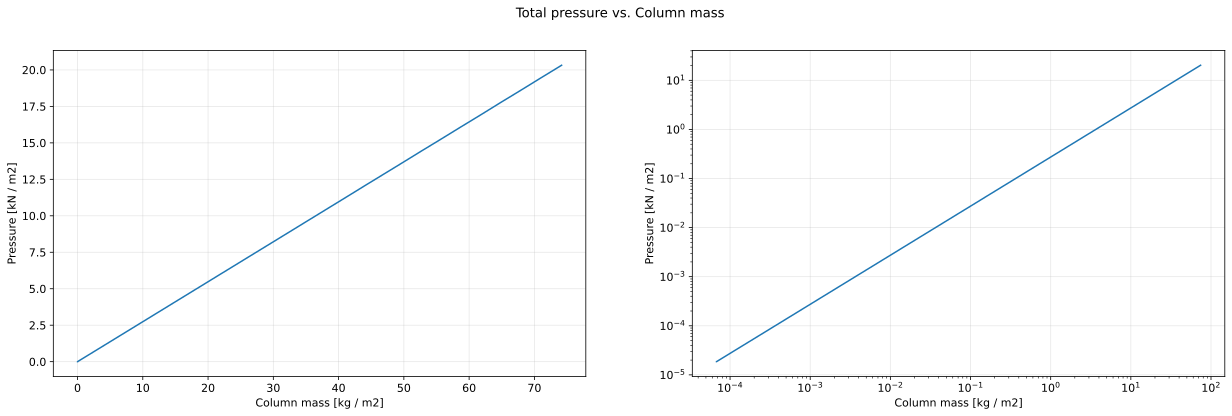

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(21, 6))
P_tot = falc["pressure"].to("kN m-2")
colmass = falc["colmass"]
ax[0].plot(colmass, P_tot)
ax[0].set_ylabel("Pressure [{}]".format(P_tot.unit))
ax[0].set_xlabel("Column mass [{}]".format(colmass.unit))
ax[0].grid(alpha=0.3)
ax[1].plot(colmass, P_tot)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel("Pressure [{}]".format(P_tot.unit))
ax[1].set_xlabel("Column mass [{}]".format(colmass.unit))
ax[1].grid(alpha=0.3)
plt.suptitle("Total pressure vs. Column mass");

We find that they both scale linearly. This is caused by the assumption that the gravity across the entire height is constant. We can see this as the hydrostatic equillibrium tells us the pressure is proportional to gravity times mass, but usually gravity is itself a function of mass $P = -g(m)m$. Therefore to get the graphs seen above, the gravity has to be assumed constant $P = cm$. We can then find the gravity that went into this model by calculating the slope of the graph(s):

In [6]:
idx_h_surface = np.argmin(abs(falc["height"]))
g_surface = (P_tot/colmass)[idx_h_surface].to("m s-2") #P/m at surface to m/s^2
g_earth = 9.81 * units.m * units.s**-2
print("g_surface       [SI] = {:.3f}".format(g_surface))
print("log(g_surface) [cgs] = {:.2f}".format(np.log10(g_surface.to("cm s-2").value))) #log10 of g in cgs units
print("log(g_earth)   [cgs] = {:.2f}".format(np.log10(g_earth.to("cm s-2").value)))

g_surface       [SI] = 274.069 m / s2
log(g_surface) [cgs] = 4.44
log(g_earth)   [cgs] = 2.99


This matches the commonly cited solar surface gravity of $\log{g} = 4.44$, indicating that this value was used. We can see that this is about $1.5$ orders of magnitude larger than the gravity on earth.

Having found the model gravity, we next want to find the abundance of metals in the model. We know the density of hydrogen and the relative number density of helium at $N_{\rm He} = 0.1 N_{\rm H}$ and their masses, letting us calculate the proportion of these elements of the total mass:

Hydrogen mean mass fraction:  0.7138
H+He mean mass fraction:      0.9972
Remaining mean mass fraction: 0.0028


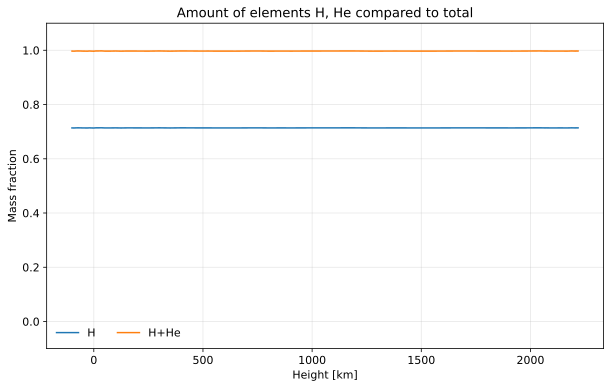

In [7]:
H_ratio = falc["hydrogen_density"]/falc["density"] * constants.m_p #m_H ~ m_p
H_and_He_ratio = H_ratio + H_ratio*0.1*3.97 #m_He = 3.97 m_p
h = falc["height"].to("km")
plt.figure(figsize=(10, 6))
plt.plot(h, H_ratio, label="H")
plt.plot(h, H_and_He_ratio, label="H+He")
plt.ylim(-0.1, 1.1)
plt.legend(ncol=2, loc=3)
plt.ylabel("Mass fraction")
plt.xlabel("Height [{}]".format(h.unit))
plt.title("Amount of elements H, He compared to total")
plt.grid(alpha=0.3)
print("Hydrogen mean mass fraction:  {:.4f}".format(np.mean(H_ratio)))
print("H+He mean mass fraction:      {:.4f}".format(np.mean(H_and_He_ratio)))
print("Remaining mean mass fraction: {:.4f}".format(1-np.mean(H_and_He_ratio)))

Our calculations show the combined hydrogen and helium fraction to be $99.72\%$, leaving only a fraction of $0.28\%$ as the metals. This is actually a smaller amount than expected, as other work such as [Asplund et al. (2009)](http://adsabs.harvard.edu/abs/2009ARA%26A..47..481A) calculates the solar photosphere to contain a metal fraction of $1.34\%$, nearly five times our model. This is not simply because we used values from the entire height, as the figure shows this to be consistent for the entire atmosphere.

Next we want to look at the gas pressure, with the goal of understanding the FALC pressure. We plot the model pressure alongside our own calculated gas pressure, one consisting of hydrogen and electrons and one with the same plus helium:

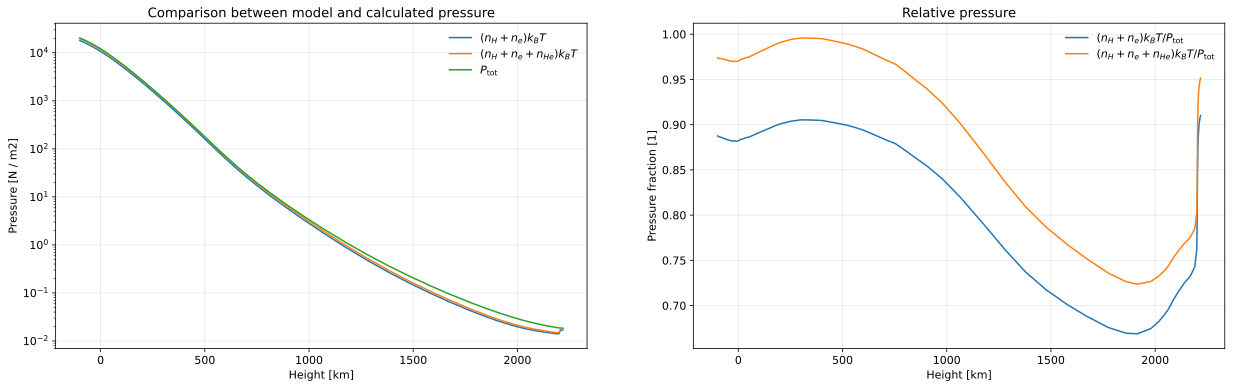

In [47]:
product1 = (falc["hydrogen_density"]+falc["electron_density"])*constants.k_B*falc["temperature"]
n_He = (H_and_He_ratio - H_ratio)*falc["density"] / (3.97 * constants.m_p)
product2 = (falc["hydrogen_density"]+falc["electron_density"]+n_He)*constants.k_B*falc["temperature"]

fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax[0].plot(h, product1.to("N m-2"), label=r"$(n_H + n_e)k_B T$")
ax[0].plot(h, product2.to("N m-2"), label=r"$(n_H + n_e + n_{He})k_B T$")
ax[0].plot(h, P_tot.to("N m-2"), label=r"$P_{\rm tot}$")
ax[0].set_yscale('log')
ax[0].set_ylabel("Pressure [N / m2]")
ax[0].set_xlabel("Height [{}]".format(h.unit))
ax[0].set_title("Comparison between model and calculated pressure")
ax[0].grid(alpha=0.3)
ax[0].legend()
ax[1].plot(h, (product1/P_tot).to("1"), label=r"$(n_H + n_e)k_B T/P_{\rm tot}$")
ax[1].plot(h, (product2/P_tot).to("1"), label=r"$(n_H + n_e + n_{He})k_B T/P_{\rm tot}$")
ax[1].set_ylabel("Pressure fraction [1]")
ax[1].set_xlabel("Height [{}]".format(h.unit))
ax[1].set_title("Relative pressure")
ax[1].grid(alpha=0.3)
ax[1].legend();

Here we see the calculated pressure compared with the FALC model pressure. They are similar enough to be hard to separate, so we also plotted the relative size of the numerical pressure to the model pressure in the right figure. Here we see that there is a clear difference, but why could this be? Given that the gas pressure is idealized using hydrostatic equillibrium, it is reasonable the difference is due to the calculated pressure not including all particles in the calculation. This is reinforced by the numerical pressure which includes helium being closer. However our previous calculation for the metal fraction suggests the remaining particles is not enough to explain the difference.

This is because the model also takes into account the turbulence by adding a fudge factor:

\begin{align*}
    P_{\rm tot} = P_{\rm gas} + \frac{\rho v_{\rm turb}^2}{2}
\end{align*}

Meaning the gas pressure we calculated is not equal the total pressure. We can show this by subtracting the turbulence factor and comparing our calculation to the remaining gas pressure:

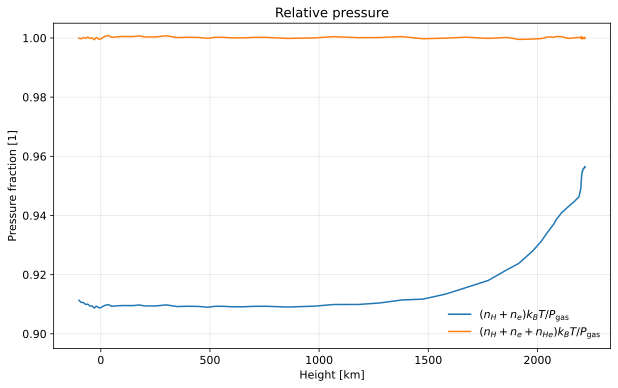

In [46]:
P_gas = P_tot - falc["density"]*falc["v_turb"]**2/2
plt.figure(figsize=(10,6))
plt.plot(h, (product1/P_gas).to("1"), label=r"$(n_H + n_e)k_B T/P_{\rm gas}$")
plt.plot(h, (product2/P_gas).to("1"), label=r"$(n_H + n_e + n_{He})k_B T/P_{\rm gas}$")
plt.ylabel("Pressure fraction [1]")
plt.xlabel("Height [{}]".format(h.unit))
plt.title("Relative pressure")
plt.ylim(0.895, 1.005)
plt.grid(alpha=0.3)
plt.legend(loc=4);

Here we can see that our relation is now nearly perfect. The minor differences remaining could then be explained by the metals (or the numerical errors in calculation).

Next we look at the fraction of hydrogen that is ionized compared to the total amount. Plotting this with a logarithmic axis gives:

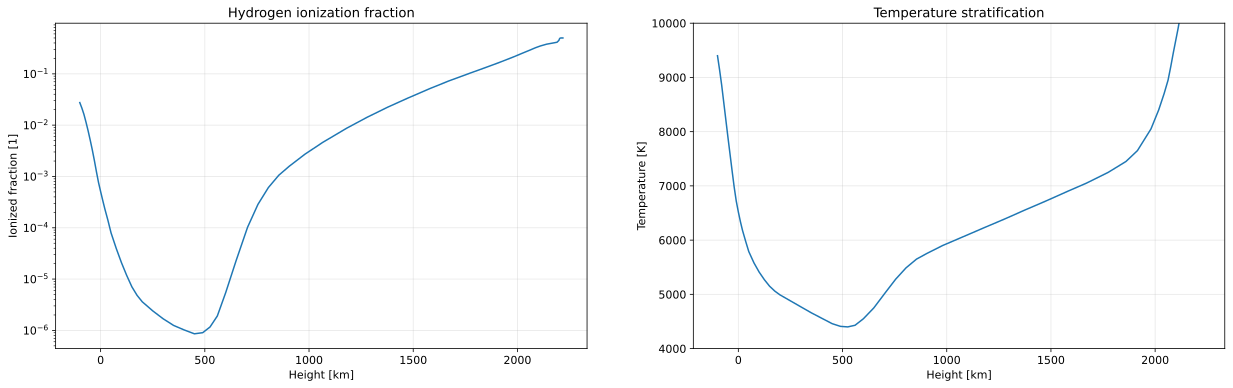

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax[0].plot(h, falc["proton_density"]/(falc["hydrogen_density"] + falc["proton_density"]))
ax[0].set_yscale('log')
ax[0].grid(alpha=0.3)
ax[0].set_title("Hydrogen ionization fraction")
ax[0].set_ylabel("Ionized fraction [1]")
ax[0].set_xlabel("Height [{}]".format(h.unit))
ax[1].plot(h, falc["temperature"])
ax[1].set_ylim(4000, 10000)
ax[1].grid(alpha=0.3)
ax[1].set_title("Temperature stratification")
ax[1].set_ylabel("Temperature [{}]".format(falc["temperature"].unit))
ax[1].set_xlabel("Height [{}]".format(h.unit));

We can see that the amount of hydrogen that is ionized generally increases by height from $h\approx 500 {\rm km}$, with a large fraction also near the surface. By plotting the temperature scale with height alongside this, we can see that they resemble eachother quite a bit. Though the ionization fraction does appear somewhat tilted with respect to the temperature. This is because the ionization near the surface could still reasonably be treated in a locally thermal equilibrium, and therefore be modeled as a Saha distribution, but this becomes less valid into the atmosphere. As this criteria fails, the the two parts of the graph start to follow different, but still similar, scales for $T$. Therefore the ionization graph follows $T$, but with a slight tilt for higher altitudes.

This is relevant in our next investigation, where we would like to model the photon number density. The general model used for this assumes intensity equal to blackbody radiation:

\begin{align*}
    u &= \frac{1}{c} \int\!\!\!\int B_\nu \mathrm{d}\Omega \mathrm{d}\nu
           = \frac{4\sigma}{c} T^4 \\
    \Rightarrow
    N_{\rm \gamma, low} &= \int_0^\infty \frac{u_\nu}{h\nu} \mathrm{d} \nu \\
            &\approx 60.42\,\left(\frac{k_B T}{hc}\right)^3
\end{align*}

Where we've used $u_\nu = {\rm d}u/{\rm d}\nu$. This is valid for the deepest location near the surface in our model, but as we go higher into the atmosphere this breaks. With no thermal equilibrium we have to modify our expression to:

\begin{align*}
    N_{\rm \gamma, high} \approx \frac{60.42}{2\pi}\,\left(\frac{k_B T_{\rm eff}}{hc}\right)^3
\end{align*}

With $T_{\rm eff}$ as the effective observed solar temperature of $5777 {\rm K}$. We plot these against the hydrogen density:

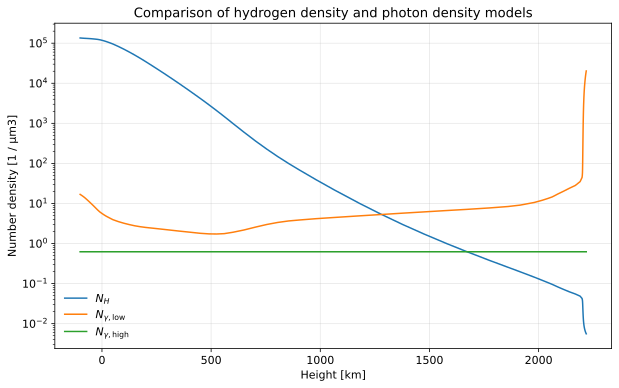

In [77]:
N_photon_low = (60.42*(constants.k_B*falc["temperature"]/(constants.h*constants.c))**3).to("micron-3")
N_photon_high = (60.42/(2*np.pi) * (constants.k_B*5777*units.K*np.ones(len(falc["temperature"]))/(constants.h*constants.c))**3).to("micron-3")
plt.figure(figsize=(10,6))
plt.plot(h, falc["hydrogen_density"].to("micron-3"), label=r"$N_H$")
plt.plot(h, N_photon_low, label=r"$N_{\gamma,{\rm low}}$")
plt.plot(h, N_photon_high, label=r"$N_{\gamma,{\rm high}}$")
plt.title("Comparison of hydrogen density and photon density models")
plt.ylabel("Number density [1 / µm3]") #µm looks better than 'micron'
plt.xlabel(f"Height [{h.unit}]")
plt.legend()
plt.grid(alpha=0.3)
plt.yscale("log")

Since the photon models are only valid in their end of the altitude, everything outside of this can be ignored. They have only been plotted for illustration purposes. We see that both models are closer to the hydrogen density in their end, but the high altitude model is much closer with only a $1-2$ magnitude difference instead of $\approx4$. Part of the reason for this is that the medium at high atmosphere is less sensetive to the photons. The gas making up this region has much less density, leaving fewer particles to absorb the photons. There are however still fewer photons overall, as they are more likely to escape at higher altitudes.

### Exercise 2: Observed Solar Continua


The file `solspect.dat` specifies the continuum radiation emitted by the sun in the wavelength range $\lambda$ = 0.2-5 μm, taken from [Allen (1976)](http://adsabs.harvard.edu/abs/1976asqu.book.....A). The data in the file are organised in five columns:

| Wavelength  | Flux (smoothed)  | Flux (continuum) | Intensity (smoothed) | Intensity (continuum)  |
| ------------- |-------------|------|------|-------------|

The units of wavelength are μm, while all the other quantities are in $10^{10}$ erg s$^{-1}$ cm$^{-2}$ μm$^{-1}$ sr$^{-1}$. "Smoothed" here means in the wavelength dimension, so that the spectral lines are not visible. The continuum versions are an attempt at measuring the true emission if there were no spectral lines. "Intensity" here refers to disk-centre intensity ($\mu=1$, centre of the solar disk), while "Flux" is the astrophysical flux.



<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Plot the four spectral distributions together in one figure over the range $\lambda$ = 0-2 μm. Check that the continuum intensity (`i_cont`) reaches $I_\lambda^c$ = 46 kW m$^{-2}$ nm$^{-1}$ sr$^{-1}$  at $\lambda$ 0.41 μm. Explain why the four distributions share the same units and discuss the differences between them.

* Convert these spectral distributions into values per frequency bandwidth $\Delta \nu$ = 1 Hz. Plot these also against wavelength. $I_\nu^c$ should have its peak of 42.1 nW m$^{-2}$ Hz$^{-1}$ sr$^{-1}$ at $\lambda$ = 0.80 μm. Discuss why the peaks of $I_\lambda$ and $I_\nu$ do not occur at the same wavelengths.

* Try to fit a Planck function to the solar continuum intensity. What rough temperature estimate do you get? Discuss.

* Compute the brightness temperature of the solar continuum against wavelength and discuss the shape of this curve. It peaks near $\lambda$ = 1.6 μm. What does that mean for the radiation escape at this wavelength? *Hint:* invert the Planck function analytically to obtain an equation that converts from intensity $I_\lambda$ into brightness temperature $T_b$ (defined by $B_\lambda(T_b) \equiv I_\lambda$).
</div>

In this task we'll compare four sets of measurements, two for flux and two for intensity. For flux and intensity the two variants correspond to a 'smoothed' and 'true' continuum. The smoothed continuum is a version of the continuum where noise and small lines have been removed, producing a smooth graph. The 'true' continuum (simply referred to the continuum from here) is an attempt to also remove the influence of larger lines, and is supposed to represent the true emission without absorption. To start we'll plot and compare the measurements, then convert the continuum intensity to frequency and fit a Planck function to estimate the temperature. Then we compute the temperature brightness of the solar continuum and discuss its shape.

We load the solar spectrum from file and plot the flux and intensity for both versions:

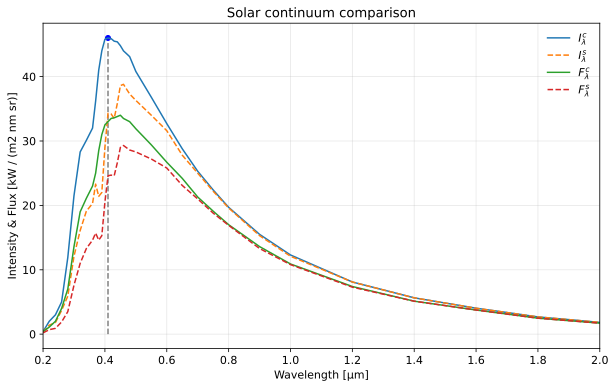

In [82]:
tmp = np.genfromtxt("solspect.dat")
lam       = tmp[:, 0] * units.micron #µm
flux_sm   = tmp[:, 1] * 10**10 * units.erg * units.s**-1 * units.cm**-2 * units.micron**-1 * units.sr**-1 #10^10 erg s-1 cm-2 µm-1 sr-1
flux_cont = tmp[:, 2] * 10**10 * units.erg * units.s**-1 * units.cm**-2 * units.micron**-1 * units.sr**-1
I_sm      = tmp[:, 3] * 10**10 * units.erg * units.s**-1 * units.cm**-2 * units.micron**-1 * units.sr**-1
I_cont    = tmp[:, 4] * 10**10 * units.erg * units.s**-1 * units.cm**-2 * units.micron**-1 * units.sr**-1

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(0.41, 46, marker="o", markersize=5, color="b")
ax.vlines(0.41, 0, 46, color="k", linestyle="--", alpha=0.5)
ax.plot(lam,    I_cont.to("kW m-2 nm-1 sr-1"),  "-", label=r"$I_\lambda^c$")
ax.plot(lam,      I_sm.to("kW m-2 nm-1 sr-1"), "--", label=r"$I_\lambda^s$")
ax.plot(lam, flux_cont.to("kW m-2 nm-1 sr-1"),  "-", label=r"$F_\lambda^c$")
ax.plot(lam,   flux_sm.to("kW m-2 nm-1 sr-1"), "--", label=r"$F_\lambda^s$")
ax.set_xlim(0.2, 2)
ax.set_title("Solar continuum comparison")
ax.set_ylabel(f"Intensity & Flux [{I_sm.to('kW m-2 nm-1 sr-1').unit}]")
ax.set_xlabel(f"Wavelength [µm]")
ax.grid(alpha=0.3)
ax.legend();

Where $I_\lambda$ is the intensity and $F_\lambda$ is the flux, and $c, s$ denote the continuum and smoothed versions respectively. The flux here refers to the astrophysical flux, which is defined as the normal flux per $\pi$ and also per unit area. The division by $\pi$ is simply in order to get the same unit as intensity. We can see that the peak of the continuum intensity matches what we expected, shown by the point at $I_\lambda(\lambda = 0.41 {\rm \mu m}) = 46$ kW m$^{-2}$ nm$^{-1}$ sr$^{-1}$.

We clearly see that the continuum intensity and flux have a larger peak than the smoothed versions, suggesting there is ususally a lot of absorption in this region. At $\lambda > 0.7 {\rm \mu m}$ however they are nearly equal. The jagged edges in the smoothed spectra also suggest there are several lines affecting this area. The flux is smaller overall, but cannot be compared directly with intensity as they only formally have the same unit due to the astrophysical flux $F_{\rm astro} = F_{\rm normal}/\pi$.

Next we convert the continuum intensity to units of frequency. To do this we use the relation:

\begin{align*}
    {\rm d}\lambda I_\lambda = -{\rm d}\nu I_\nu \Rightarrow I_\nu = -\frac{{\rm d}\lambda}{{\rm d}\nu}I_\lambda
\end{align*}

And derivate numerically to find the conversion factor, giving $I_\nu$:

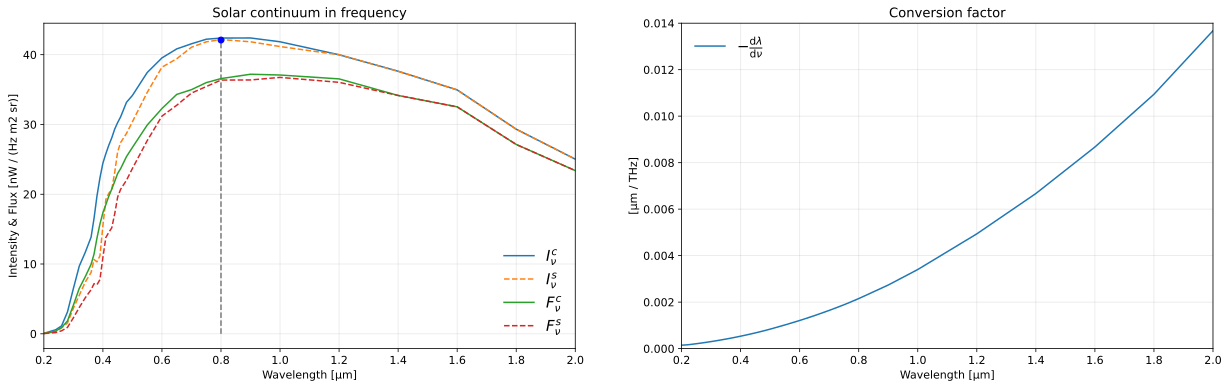

In [101]:
conv = -np.gradient(lam, lam.to("Hz", equivalencies=units.spectral()))
fig, ax = plt.subplots(1, 2, figsize=(21,6))
ax[0].plot(lam,    (I_cont*conv).to("nW m-2 Hz-1 sr-1"),  "-", label=r"$I_\nu^c$")
ax[0].plot(lam,      (I_sm*conv).to("nW m-2 Hz-1 sr-1"), "--", label=r"$I_\nu^s$")
ax[0].plot(lam, (flux_cont*conv).to("nW m-2 Hz-1 sr-1"),  "-", label=r"$F_\nu^c$")
ax[0].plot(lam,   (flux_sm*conv).to("nW m-2 Hz-1 sr-1"), "--", label=r"$F_\nu^s$")
ax[0].plot(0.8, 42.1, marker="o", color="b")
ax[0].vlines(0.8, 0, 42.1, color="k", linestyle="--", alpha=0.5)
ax[0].set_xlim(0.2, 2)
ax[0].legend(fontsize=15)
ax[0].grid(alpha=0.3)
ax[0].set_title("Solar continuum in frequency")
ax[0].set_ylabel(f"Intensity & Flux [{(I_sm*conv).to('nW m-2 Hz-1 sr-1').unit}]")
ax[0].set_xlabel("Wavelength [µm]")
ax[1].plot(lam, conv.to("micron THz-1"), label=r"$-\frac{{\rm d}\lambda}{{\rm d}\nu}$")
ax[1].set_xlim(0.2, 2)
ax[1].set_ylim(0, 0.014)
ax[1].set_title("Conversion factor")
ax[1].set_ylabel("[µm / THz]")
ax[1].set_xlabel("Wavelength [µm]")
ax[1].legend(fontsize=15)
ax[1].grid(alpha=0.3)

In the left figure we can see that the intensity valued for frequency peaks at $I_\nu(\lambda = 0.8 {\rm \mu m}) = 42.1$ nW m$^{-2}$ Hz$^{-1}$ sr$^{-1}$ as we hoped. Something worth noting however is that this peak is not at the same wavelength as before. This is since the factor $\frac{{\rm d}\lambda}{{\rm d}\nu}$ used to convert does not scale linearly. Since $\lambda = c/\nu$, this factor can be expressed as:

\begin{align*}
    \frac{{\rm d}\lambda}{{\rm d}\nu} = \frac{{\rm d}}{{\rm d}\nu}\frac{c}{\nu} = -\frac{c}{\nu^2} = -\frac{1}{c}\lambda^2
\end{align*}

Which we see scales as the wavelength squared. The factor has been plotted in the right figure. This means the transition to $I_\nu$ will disproportionally increase the right hand side of the plot, making the peak shift towards higher wavelengths.

In order to find the temperature at which this occured, we fit a Planck function to this intensity:

T_fit = 6300.366116175714 K


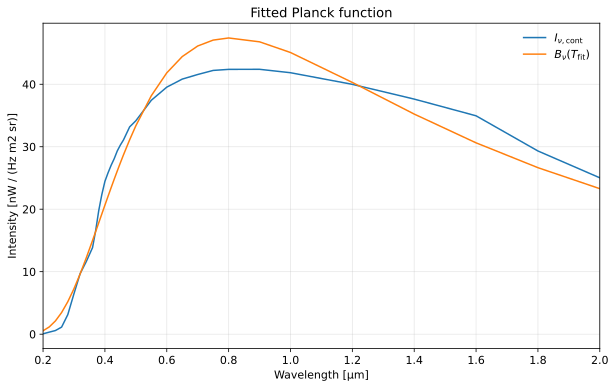

In [105]:
def bb(lam, T):
    return BlackBody(T*units.K)(lam*units.micron).value
popt, pcov = curve_fit(bb, lam.value, I_cont*conv, p0=5777)

plt.figure(figsize=(10,6))
plt.plot(lam, (I_cont*conv).to("nW m-2 Hz-1 sr-1"), label=r"$I_{\nu, {\rm cont}}$")
plt.plot(lam, BlackBody(popt[0]*units.K)(lam).to("nW m-2 Hz-1 sr-1"), label=r"$B_\nu(T_{\rm fit})$")
plt.title("Fitted Planck function")
plt.xlabel("Wavelength [µm]")
plt.ylabel(f"Intensity [{(I_cont*conv).to('nW m-2 Hz-1 sr-1').unit}]")
plt.legend()
plt.xlim(0.2, 2)
plt.grid(alpha=0.3)
print("T_fit =", popt[0], "K")

The fitting gives back a best parameter of $6300$ K. This is larger than the generally used value for the suns surface of $5778$ K. The reason for this is that our continuum is an attempt at the 'true' emission before any possible absorption. It has a large amount of extra energy, which leads to a better fit for a larger temperature.

Defining our intensity equal to the Planck function and in we can calculate the temperature brightness:

\begin{align*}
    I_\nu \equiv B_\nu(T_b) = \frac{2h\nu}{c^2}\frac{1}{e^{\frac{h\nu}{k_BT}}-1} \Rightarrow T_b = \frac{h\nu}{k_B}\ln^{-1}\bigg(1+\frac{2h\nu^3}{I_\nu c^2}\bigg)
\end{align*}

Which we apply to get the temperature curve of the solar continuum, and compare to the fitted temperature:

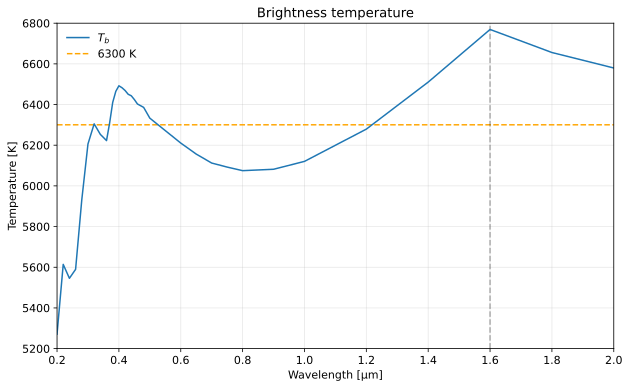

In [106]:
nu = lam.to("Hz", equivalencies=units.spectral())
I_cont_nu = I_cont*conv
T_b = (constants.h*nu/constants.k_B * np.log(1 + 2*constants.h*nu**3/(I_cont_nu*constants.c**2)/units.sr)**-1).to("K")
plt.figure(figsize=(10,6))
plt.plot(lam, T_b, label=r"$T_b$")
plt.title("Brightness temperature")
plt.hlines(popt[0], xmin=min(lam.value), xmax=max(lam.value), linestyle="--", colors="orange", label="{:.0f} K".format(popt[0]))
plt.vlines(1.6, 5200, 6800, linestyle="--", colors="k", alpha=0.3)
plt.xlabel("Wavelength [µm]")
plt.ylabel(f"Temperature [{T_b.unit}]")
plt.xlim(0.2, 2)
plt.ylim(5200, 6800)
plt.legend()
plt.grid(alpha=0.3)

The resulting plot when compared with the fitted temperature displays where the intensity diverges from the blackbody radiation. We can see this by comparing with the previous plot and seeing that the brightness temperature is larger than the fitted temperature at the same place where the intensity is larger than the fitted Planck function (and vice-versa). This means the peak observed at $\lambda = 1.6 {\rm \mu m}$ is due to the excess radiation observed at this wavelength in the solar continuum, meaning more radiation passes through this layer when compared to the expected blackbody radiation.

### Exercise 3: Continuous Extinction

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Plot the extinction coefficient $\alpha_\lambda^c$ using only H$^-$ extinction (bound-free and free-free, use `compute_hminus_cross_section`) as function of wavelength, for wavelengths between 300-2000 nm, and for the temperature and density at the solar surface (height = 0) in the FALC model.
    
* Hydrogenic bound-free edges behave just as H$^-$ with maximum extinction at the ionisation limit and decay $\sim \lambda^3$ for smaller wavelengths, as indeed shown by the H$^-$ curve. The H$^-$ bound-free extinction differs strongly from this pattern. Why is it not hydrogenic although due to hydrogen?

* How can you manipulate $\alpha_\lambda^c$ to make a plot that looks like the the solar brightness temperature variation with wavelength? Why?

* Compute and plot $\alpha_\lambda^c$ from H$^-$ as a function of height for the FALC model, at $\lambda$ = 0.5 μm. This plot needs to be logarithmic in y, why?

* Now add the Thomson scattering off free electrons to the extinction coefficient $\alpha_\lambda^c$. The Thomson cross-section per electron is the same at all wavelengths and is given by       
\begin{equation*}
        \sigma^{\rm T} = 6.652 \times 10^{-29} \rm{m}^2.
\end{equation*} 
By which height-dependent quantity do you have to multiply $\sigma^{\rm T}$ to obtain extinction per m? Plot the total $\alpha_\lambda^c=\alpha_\lambda^{H-} + \alpha^T$ as well as the separate components for H$^-$ and Thomson scattering at 0.5 μm as a function of height for the FALC model. Discuss.
    
* The photon scattering probability, let's call it $\zeta_\lambda$, gives the probability that a photon will be scattered (instead of absorbed) when it interacts with another particle. It can be defined as:
\begin{equation*}
        \zeta_\lambda = \frac{\alpha_\lambda^s}{\alpha_\lambda^a+\alpha_\lambda^s},
\end{equation*} 
    where $\alpha_\lambda^s$ is the extinction from scattering processes and $\alpha_\lambda^a$ is the extinction from absorption processes. Assuming that all H$^-$ extinction results only in absorption, plot $\zeta_\lambda$ at 0.5 μm as a function of height for the FALC model, using only the extinction sources you've considered so far (H$^-$ and Thomson scattering). Discuss how this relates to the plot you made in the previous point.
</div>

In this exercise we discuss the extinction through $H^-$. We will compute the extinction coefficient of $H^-$ using its cross-section at the solar surface, and find a relation to the temperature. Then we calculate the same coefficient as a function of height, which we will use to compare with the Thompson cross-section. Finally we will put these together to get an estimate of the photon scattering probability per height.

Since the cross-section is defined per neutral hydrogen atom, we multiply by the number density of neutral hydrogen to find the extinction coefficient and plot it at surface height values:

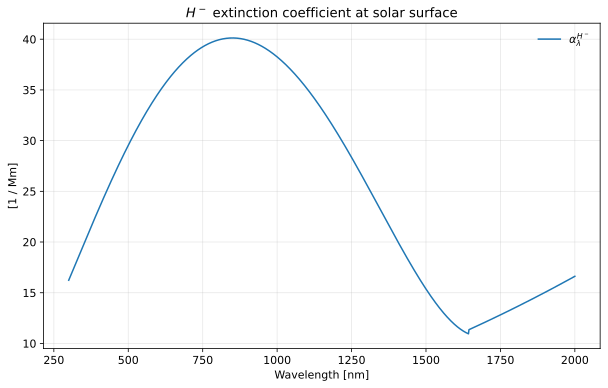

In [134]:
import warnings; warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) #ignoring numpy warning

wav = np.linspace(300, 2000, 1000)*units.nm
n_e_surface = falc["electron_density"][idx_h_surface]
cross = compute_hminus_cross_section(wav, 5777*units.K, n_e_surface)[0]
alpha_wav = (cross*(falc["hydrogen_density"] - falc["proton_density"])[idx_h_surface]).to('Mm-1')

plt.figure(figsize=(10,6))
plt.plot(wav, alpha_wav, label=r"$\alpha_\lambda^{H^-}$")
plt.title(r"$H^-$ extinction coefficient at solar surface")
plt.xlabel(f"Wavelength [{wav.unit}]")
plt.ylabel(f"[{alpha_wav.unit}]")
plt.legend()
plt.grid(alpha=0.3)

The parabolic part is the bound-free extinction, while the line from $\approx 1600 {\rm nm}$ is caused by the free-free extinction. Notably the $H^-$ curve does not follow the standard pattern of hydrogenic extinction, despite being a hydrogen atom. This is because the definition of a hydrogenic atom is to have one valence electron, whereas our $H^-$ has two free electrons. Therefore it does not get the distinct edge at the maximum, and instead gets a smooth curve due to the interplay of two.

It does however fit another pattern we've seen. The parabola and extinction edge roughly correspond to the brightness temperature we calculated before. Though for them to follow eachother, we need to inverse $\alpha_\lambda^{H^-}$:

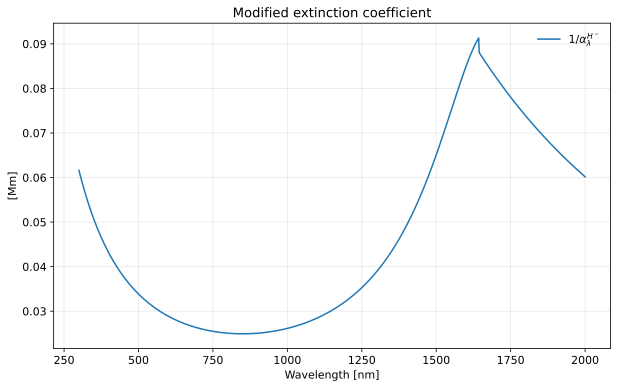

In [135]:
plt.figure(figsize=(10,6))
plt.plot(wav, 1/alpha_wav, label=r"$1/\alpha_\lambda^{H^-}$")
plt.title("Modified extinction coefficient")
plt.xlabel(f"Wavelength [{wav.unit}]")
plt.ylabel(f"[{alpha_wav.unit**-1}]")
plt.legend()
plt.grid(alpha=0.3)

Note the large curve and edge at $1650 {\rm nm} \approx 16 {\rm \mu m}$ found in both this figure and the brightness temperature. The reason why the extinction goes as the inverse of brightness temperature is that the temperature is caused by the extinction. Approximating the intensity from the surface as a blackbody, we found earlier that the brightness temperature displayed the difference from the blackbody temperature at different wavelengths. The reason for this difference was the extinction causing absorption in the solar atmosphere. Positive extinction causes negative temperature down the line, which gives the inverse relationship observed here.

Continuing with the extinction factor, we now pin the wavelength to $500 {\rm nm}$ and look at variation with height:

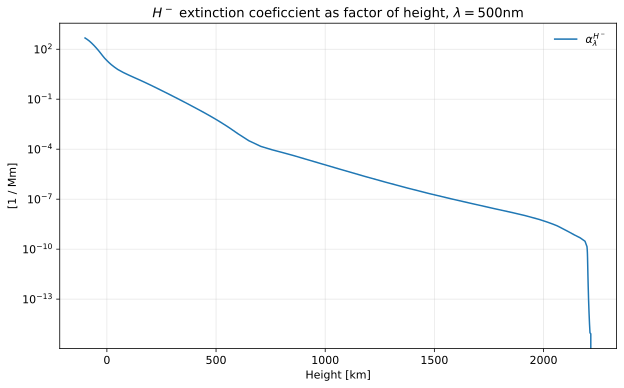

In [136]:
cross_500 = np.array([compute_hminus_cross_section(500*units.nm, Ti, ei) for Ti, ei in zip(falc["temperature"], falc["electron_density"])])[:, 0] * units.m**2 #manually adding back unit
alpha_h = (cross_500*(falc["hydrogen_density"] - falc["proton_density"])).to("Mm-1")
plt.figure(figsize=(10,6))
plt.plot(h, alpha_h, label=r"$\alpha_\lambda^{H^-}$")
plt.yscale('log')
plt.title(r"$H^-$ extinction coeficcient as factor of height, $\lambda = 500 {\rm nm}$")
plt.xlabel(f"Height [{h.unit}]")
plt.ylabel(f"[{alpha_h.unit}]")
plt.legend()
plt.grid(alpha=0.3)

Since the coefficient has a factor of density, we need this plot on a logarithmic axis to keep up with the large drop during ascent. At the top of our range it drops to $\log(\alpha_\lambda^{H^-})\approx -16$ as the height reaches the transition region between chromosphere and corona.

We combine this with the Thompson factor to get an expression for the total extinction for these factors. The Thompson coeficcient is given per electron, so we multiply by the number density to recieve:

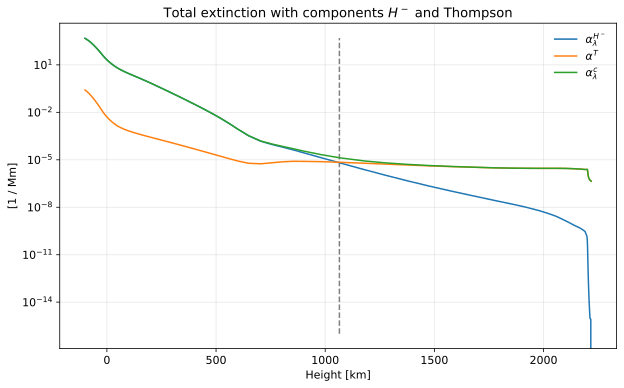

In [163]:
alpha_T = 6.652e-29 * units.m**2 * falc["electron_density"]
alpha_tot = alpha_h + alpha_T #0.5 µm = 500 nm, same as before
plt.figure(figsize=(10,6))
plt.plot(h, alpha_h, label=r"$\alpha_\lambda^{H^-}$")
plt.plot(h, alpha_T, label=r"$\alpha^T$")
plt.plot(h, alpha_tot, label=r"$\alpha_\lambda^c$")
plt.title(r"Total extinction with components $H^-$ and Thompson")
plt.xlabel(f"Height [{h.unit}]")
plt.ylabel(f"[{alpha_h.unit}]")
plt.legend()
plt.yscale('log')
plt.vlines(h[np.argmin(abs(alpha_h/alpha_T - 1))], 1e-16, 5e2, linestyle="--", color="k", alpha=0.5)
plt.grid(alpha=0.3)

We can see that both the Thompson scattering and $H^-$ absorption dominate at different ends of the height spectrum. Near the surface the $H^-$ coefficient is dominant, leading the total extinction. Whereas at the top of our range the Thommpson scattering is many magnitudes larger. Together they meet in the middle at a height of $1000-1100 {\rm km}$. This represents where a photon is equally likely to either scatter or get absorbed by these processes. Outside of this one of the methods of extinction rule over the other.

To get a better look at the relative probability, we assume these to be the only possible fates of a photon. We define the photon scattering probability:

\begin{align*}
    \xi_\lambda = \frac{\alpha_\lambda^T}{\alpha_\lambda^T + \alpha_\lambda^{H^-}}
\end{align*}

Which defines the chance a photon gets scattered by the Thompson effect given that only it and the $H^-$ absorption are its possibilities. Given that this is a function in domain $[0, 1]$, the odds of a photon being absorbed can equally be calculated as $1-\xi_\lambda$. We plot the function by height:

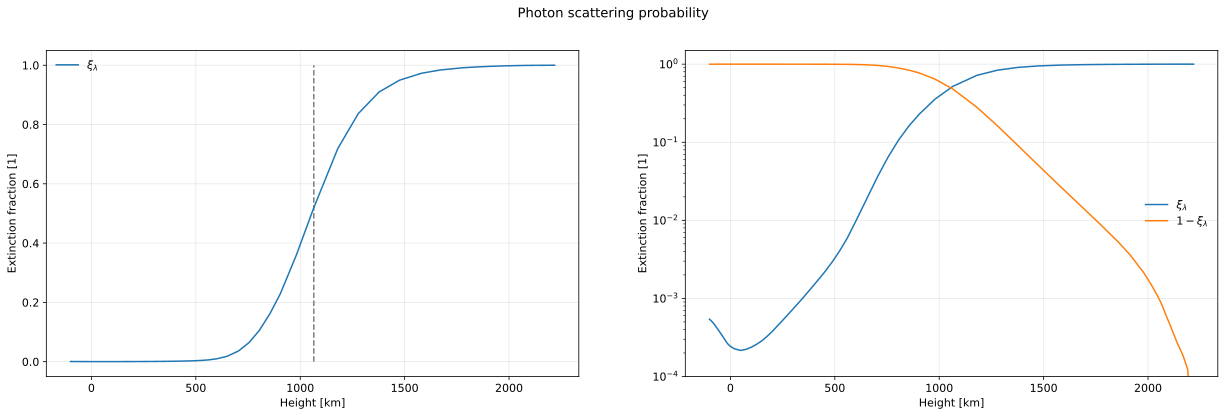

In [167]:
xi = alpha_T/(alpha_T+alpha_h)
fig, ax = plt.subplots(1, 2, figsize=(21,6))
ax[0].plot(h,xi, label=r"$\xi_\lambda$")
ax[0].set_xlabel(f"Height [{h.unit}]")
ax[0].set_ylabel("Extinction fraction [1]")
ax[0].legend()
ax[0].vlines(h[np.argmin(abs(alpha_h/alpha_T - 1))], 0, 1, linestyle="--", color="k", alpha=0.5)
ax[0].grid(alpha=0.3)
ax[1].plot(h,xi, label=r"$\xi_\lambda$")
ax[1].plot(h,1-xi, label=r"$1-\xi_\lambda$")
ax[1].set_xlabel(f"Height [{h.unit}]")
ax[1].set_ylabel("Extinction fraction [1]")
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_ylim(1e-4, 1.5) #highlighting
ax[1].grid(alpha=0.3)
plt.suptitle("Photon scattering probability");

Here we see that the two methods are roughly equally likely, and at each end their probability reaches $100\%$. At the middle the graph reaches $50\%$ at the same height as the graphs met in the previous figure. However by plotting the same function on a logarithmic scale, we can see that the Thompson scattering does not reach zero in the lower end as the $H^-$ absorption does in the top. Below the surface it seems as if this probability actually increases, only if a small amount.